# Exploratory Data Analysis

## Imports and constants

In [1]:
%load_ext autoreload
%autoreload 2

import os
from typing import Dict, Any
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
from transformers import AutoTokenizer
from datasets import load_dataset

from defi_textmine_2025.data import (
    load_labeled_raw_data,
    load_test_raw_data,
    clean_raw_dataset,
    print_value_types,
    save_data,
    TextToMultiLabelDataGenerator,
)
from defi_textmine_2025.data import TARGET_COL, INPUT_COLS, INTERIM_DIR, EDA_DIR

VALIDATION_RATE = 0.25
BASE_CHECKPOINT = "camembert/camembert-base"

tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINT)
def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])

[05:47:37|INFO|config.py:58] PyTorch version 2.3.1 available.
[05:47:37|INFO|config.py:105] TensorFlow version 2.16.2 available.
/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Loading data

In [2]:
labeled_raw_df = load_labeled_raw_data()
labeled_raw_df

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{""id"": 0, ""mentions"": [{""value"": ""accident"", ...","[[0, ""STARTED_IN"", 9], [7, ""IS_LOCATED_IN"", 9]..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{""id"": 0, ""mentions"": [{""value"": ""explosé"", ""...","[[9, ""IS_LOCATED_IN"", 8], [11, ""OPERATES_IN"", ..."
51470,"En Espagne, dans une région agricole, une cont...","[{""id"": 0, ""mentions"": [{""value"": ""contaminati...","[[7, ""IS_PART_OF"", 8], [9, ""OPERATES_IN"", 1], ..."
51332,Un important incendie a fait des ravages dans ...,"[{""id"": 0, ""mentions"": [{""value"": ""incendie"", ...","[[12, ""IS_IN_CONTACT_WITH"", 5], [0, ""IS_LOCATE..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{""id"": 0, ""mentions"": [{""value"": ""renversé"", ...","[[9, ""IS_LOCATED_IN"", 2], [0, ""START_DATE"", 17..."
...,...,...,...
1288,"M. Thibault Alekseï, membre de l'association ""...","[{""id"": 0, ""mentions"": [{""value"": ""perdu le co...","[[2, ""IS_PART_OF"", 3], [12, ""IS_IN_CONTACT_WIT..."
3822,Des employés d'une usine de production médical...,"[{""id"": 0, ""mentions"": [{""value"": ""grève"", ""st...","[[8, ""HAS_CONTROL_OVER"", 7], [4, ""HAS_CATEGORY..."
51266,"Le 13 mars 2001, Belgrade a connu un krach bou...","[{""id"": 0, ""mentions"": [{""value"": ""krach bours...","[[1, ""STARTED_IN"", 3], [10, ""IS_PART_OF"", 4], ..."


In [3]:
test_raw_df = load_test_raw_data()
test_raw_df

,text,entities
id,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{""id"": 0, ""mentions"": [{""value"": ""crash"", ""st..."
4909,"48 heures après le braquage du ""DC Supermarket...","[{""id"": 0, ""mentions"": [{""value"": ""DC Supermar..."
2353,"À Genève, la boîte de nuit ""Pretty Woman"" a en...","[{""id"": 0, ""mentions"": [{""value"": ""tombé"", ""st..."
1210,"À Caracas, l'an dernier, une mine située à l'o...","[{""id"": 0, ""mentions"": [{""value"": ""effondremen..."
41948,"À Genève, une industrie de fabrication d'arbre...","[{""id"": 0, ""mentions"": [{""value"": ""incendiée"",..."
...,...,...
51452,"Le WOOP, une organisation mondiale, avait prop...","[{""id"": 0, ""mentions"": [{""value"": ""épidémie"", ..."
51491,"Madame Pautrat Elina, dirigeante de l’associat...","[{""id"": 0, ""mentions"": [{""value"": ""pollution"",..."
51492,"Monsieur Elirone Trameur, membre de l’associat...","[{""id"": 0, ""mentions"": [{""value"": ""pollution"",..."


## Analysing raw data

### Check value types

In [4]:
labeled_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 181 to 124
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       800 non-null    object
 1   entities   800 non-null    object
 2   relations  800 non-null    object
dtypes: object(3)
memory usage: 25.0+ KB


In [5]:
test_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1204 to 51742
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      400 non-null    object
 1   entities  400 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB


In [6]:
# types of values in train data
print_value_types(labeled_raw_df)

text <class 'str'>
entities <class 'str'>
relations <class 'str'>


In [7]:
# types of values in test data
print_value_types(test_raw_df)

text <class 'str'>
entities <class 'str'>


### Check for duplicated rows

In [8]:
labeled_raw_df[labeled_raw_df.duplicated()]

,text,entities,relations
id,,,


In [9]:
test_raw_df[test_raw_df.duplicated()]

,text,entities
id,,


### Check for missing values

In [10]:
labeled_raw_df.isnull().sum()

text         0
entities     0
relations    0
dtype: int64

In [11]:
test_raw_df.isnull().sum()

text        0
entities    0
dtype: int64

In [12]:
labeled_raw_df.relations.sort_values()

id
41601    [[0, "DEATHS_NUMBER", 14], [3, "RESIDES_IN", 4...
2514     [[0, "END_DATE", 11], [0, "IS_LOCATED_IN", 4],...
1223     [[0, "END_DATE", 11], [10, "START_DATE", 11], ...
2329     [[0, "END_DATE", 11], [4, "RESIDES_IN", 1], [0...
3898     [[0, "END_DATE", 9], [5, "OPERATES_IN", 7], [1...
                               ...                        
4964     [[9, "IS_LOCATED_IN", 5], [8, "OPERATES_IN", 5...
41071    [[9, "IS_LOCATED_IN", 5], [9, "IS_LOCATED_IN",...
31669    [[9, "IS_LOCATED_IN", 8], [11, "OPERATES_IN", ...
41918    [[9, "IS_LOCATED_IN", 8], [13, "HAS_CONTROL_OV...
155      [[9, "OPERATES_IN", 1], [0, "IS_LOCATED_IN", 4...
Name: relations, Length: 800, dtype: object

## Data Cleaning/Wrangling

### Fix value typing

In [13]:
labeled_clean_df = clean_raw_dataset(labeled_raw_df)
test_clean_df = clean_raw_dataset(test_raw_df)

In [14]:
assert (labeled_raw_df.index == labeled_clean_df.index).all()
assert (test_raw_df.index == test_clean_df.index).all()

In [15]:
test_raw_df.head(1)

,text,entities
id,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{""id"": 0, ""mentions"": [{""value"": ""crash"", ""st..."


In [16]:
test_clean_df.head(1)

,text,entities,relations
id,,,
1204,“FEAR” est une organisation spécialisée dans l...,"[{'id': 0, 'mentions': [{'value': 'crash', 'st...",None


### Check value types

In [17]:
# types of values in train data
print_value_types(labeled_clean_df)

text <class 'str'>
entities [  [<class 'str'>, <class 'str'>, <class 'str'>]  ]
relations [  <class 'list'>  ]


In [18]:
# types of values in test data
print_value_types(test_clean_df)

text <class 'str'>
entities [  [<class 'str'>, <class 'str'>, <class 'str'>]  ]
relations <class 'NoneType'>


### Save cleaned datasets

For manual analysis

In [19]:
save_data(labeled_clean_df, os.path.join(INTERIM_DIR, "train_cleaned.csv"))
save_data(test_clean_df, os.path.join(INTERIM_DIR, "test_cleaned.csv"))

## Analyze clean data

### All relation types

In [20]:
relation_classes = set(
    sum(
        labeled_clean_df.relations.apply(
            lambda row: list({r for (e1, r, e2) in row})
        ).values.tolist(),
        [],
    )
)
print(len(relation_classes))
relation_classes

37


{'CREATED',
 'DEATHS_NUMBER',
 'DIED_IN',
 'END_DATE',
 'GENDER_FEMALE',
 'GENDER_MALE',
 'HAS_CATEGORY',
 'HAS_COLOR',
 'HAS_CONSEQUENCE',
 'HAS_CONTROL_OVER',
 'HAS_FAMILY_RELATIONSHIP',
 'HAS_FOR_HEIGHT',
 'HAS_FOR_LENGTH',
 'HAS_FOR_WIDTH',
 'HAS_LATITUDE',
 'HAS_LONGITUDE',
 'HAS_QUANTITY',
 'INITIATED',
 'INJURED_NUMBER',
 'IS_AT_ODDS_WITH',
 'IS_BORN_IN',
 'IS_BORN_ON',
 'IS_COOPERATING_WITH',
 'IS_DEAD_ON',
 'IS_IN_CONTACT_WITH',
 'IS_LOCATED_IN',
 'IS_OF_NATIONALITY',
 'IS_OF_SIZE',
 'IS_PART_OF',
 'IS_REGISTERED_AS',
 'OPERATES_IN',
 'RESIDES_IN',
 'STARTED_IN',
 'START_DATE',
 'WAS_CREATED_IN',
 'WAS_DISSOLVED_IN',
 'WEIGHS'}

#### Summary stats on relation classes

<Axes: xlabel='Number of texts containing the relation', ylabel='Relation'>

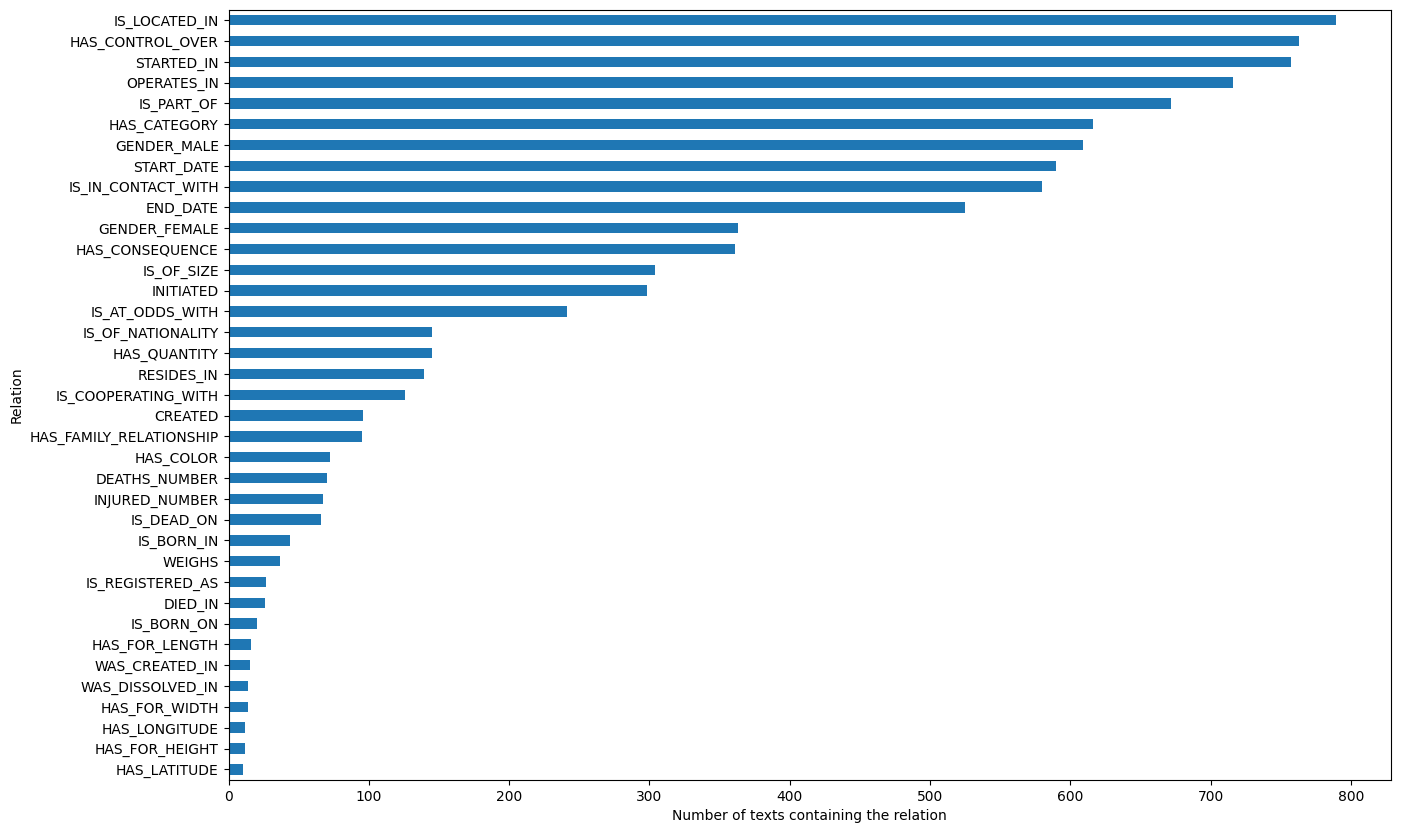

In [21]:
# number of text containing a relation category

plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df[labeled_raw_df.relations.str.contains(cat)].shape[0] for cat in relation_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of texts containing the relation", ylabel="Relation")

In [22]:
labeled_raw_df.relations.str.count("CREATED").sum()

141

In [23]:
# distribution of the occurences of each category among texts
pd.DataFrame({cat: labeled_raw_df.relations.str.count(cat) for cat in relation_classes}).describe().T.sort_values("50%", ascending=False)

,count,mean,std,min,25%,50%,75%,max
IS_LOCATED_IN,800.0,11.28125,6.555025,0.0,7.0,10.0,15.0,44.0
HAS_CONTROL_OVER,800.0,5.68375,3.724389,0.0,3.0,5.0,8.0,22.0
IS_IN_CONTACT_WITH,800.0,3.64875,4.583026,0.0,0.0,2.0,4.0,44.0
STARTED_IN,800.0,2.32500,1.829223,0.0,1.0,2.0,3.0,12.0
OPERATES_IN,800.0,3.04375,2.650588,0.0,1.0,2.0,4.0,19.0
IS_PART_OF,800.0,1.82750,1.642747,0.0,1.0,1.0,2.0,14.0
START_DATE,800.0,1.29250,1.165608,0.0,0.0,1.0,2.0,7.0
END_DATE,800.0,1.09250,1.081853,0.0,0.0,1.0,2.0,6.0
GENDER_MALE,800.0,1.13500,0.864702,0.0,1.0,1.0,2.0,4.0
HAS_CATEGORY,800.0,1.11750,0.891452,0.0,1.0,1.0,2.0,5.0


In [24]:
labeled_raw_df.relations.str.count("IS_LOCATED_IN")

id
181      17
31669    14
51470     5
51332     3
1131      8
         ..
1288     14
3822      6
51266     7
51368    13
124      23
Name: relations, Length: 800, dtype: int64

In [25]:
labeled_clean_df.relations.loc[181]

[[0, 'STARTED_IN', 9],
 [7, 'IS_LOCATED_IN', 9],
 [5, 'IS_LOCATED_IN', 10],
 [1, 'GENDER_FEMALE', 1],
 [12, 'IS_LOCATED_IN', 10],
 [0, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 10],
 [13, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 10],
 [1, 'HAS_CATEGORY', 18],
 [5, 'IS_LOCATED_IN', 9],
 [9, 'IS_LOCATED_IN', 10],
 [14, 'IS_DEAD_ON', 15],
 [7, 'HAS_CATEGORY', 19],
 [12, 'IS_LOCATED_IN', 9],
 [0, 'IS_LOCATED_IN', 9],
 [7, 'GENDER_MALE', 7],
 [11, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 9],
 [14, 'HAS_CATEGORY', 20],
 [0, 'STARTED_IN', 10],
 [0, 'START_DATE', 15],
 [7, 'IS_LOCATED_IN', 10],
 [0, 'END_DATE', 15],
 [14, 'GENDER_MALE', 14],
 [12, 'IS_OF_SIZE', 22],
 [13, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 11],
 [13, 'IS_OF_SIZE', 21]]

In [26]:
# Total occurences of each category in the labeled dataset
pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=False)

IS_LOCATED_IN              9025
HAS_CONTROL_OVER           4547
IS_IN_CONTACT_WITH         2919
OPERATES_IN                2435
STARTED_IN                 1860
IS_AT_ODDS_WITH            1526
IS_PART_OF                 1462
START_DATE                 1034
GENDER_MALE                 908
HAS_CATEGORY                894
END_DATE                    874
HAS_CONSEQUENCE             769
INITIATED                   469
IS_OF_SIZE                  438
GENDER_FEMALE               414
IS_COOPERATING_WITH         372
RESIDES_IN                  222
HAS_FAMILY_RELATIONSHIP     222
HAS_QUANTITY                191
IS_OF_NATIONALITY           179
CREATED                     141
HAS_COLOR                    91
DEATHS_NUMBER                75
INJURED_NUMBER               70
IS_DEAD_ON                   68
IS_BORN_IN                   50
DIED_IN                      41
WEIGHS                       41
IS_REGISTERED_AS             34
IS_BORN_ON                   20
HAS_FOR_LENGTH               16
WAS_CREA

<Axes: title={'center': 'Total occurences of each category in the labeled dataset'}, xlabel='Number of labeled relations of a given category', ylabel='Category of relation'>

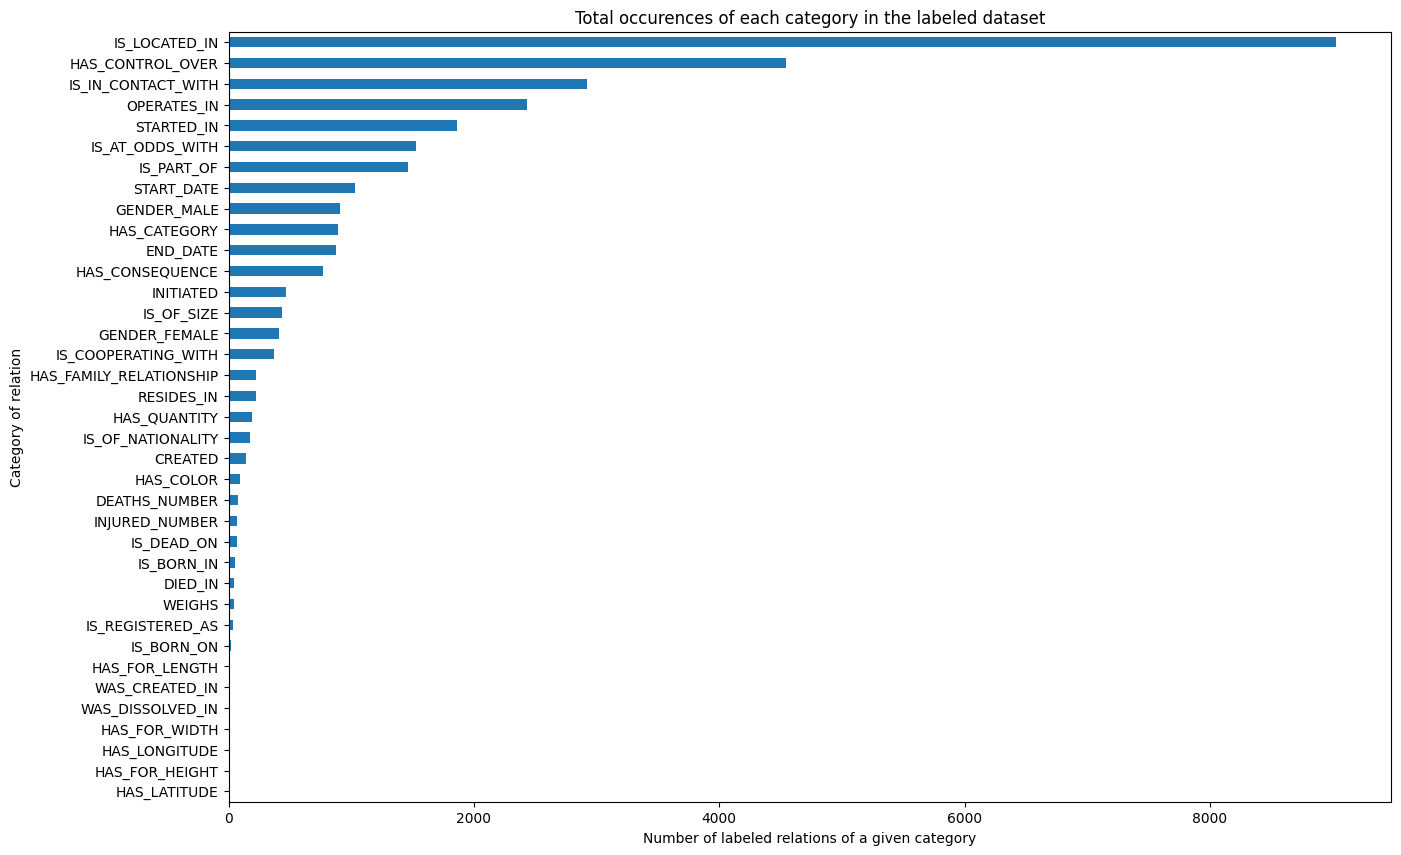

In [27]:
plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of labeled relations of a given category", ylabel="Category of relation", title="Total occurences of each category in the labeled dataset")
# pd.Series({cat: labeled_raw_df.relations.str.count(cat).sum() for cat in relation_classes}).sort_values(ascending=False)

#### How many relations can we expect to extract from a text?

count    800.00000
mean      39.33625
std       17.50339
min        4.00000
25%       27.00000
50%       37.00000
75%       48.00000
max      143.00000
Name: relations, dtype: float64


<Axes: >

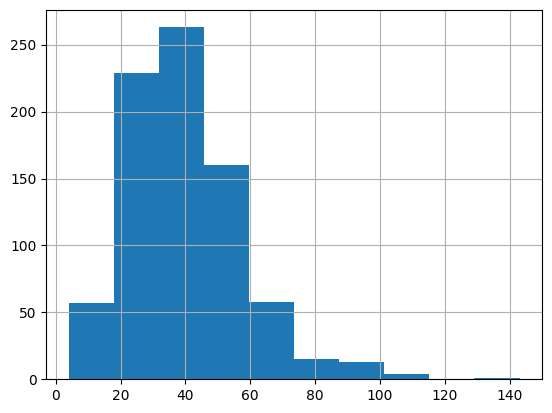

In [35]:
n_relations_per_text_df = labeled_clean_df.relations.map(lambda x: len(x))
print(n_relations_per_text_df.describe())
n_relations_per_text_df.hist()

### All entity types

In [ ]:
entity_classes = set(
    sum(
        labeled_clean_df.entities.apply(
            lambda row: list({e["type"] for e in row})
        ).values.tolist(),
        [],
    )
)
print(len(entity_classes))
entity_classes

#### Summary stats on entity classes

* entity type frequencies

In [ ]:
labeled_raw_df[labeled_raw_df.entities.str.contains("MATERIEL")].head()

In [ ]:
plt.figure(figsize=(15, 10))
pd.Series({cat: labeled_raw_df[labeled_raw_df.entities.str.contains(cat)].shape[0] for cat in entity_classes}).sort_values(ascending=True).plot.barh(xlabel="Number of texts containing the entity", ylabel="Entity")

### Stats about the cooccurence between entity categories and relation categories

TODO: For each relation category:
- what is the number of time each entity category is e1?
- what is the number of time each entity category is e2?
- what pairs of entity categories are never into a relation?

In [ ]:
labeled_clean_df.values

In [ ]:

entity_relation_cat_df  = pd.concat(
    [
        pd.DataFrame([[text_entities[e1_id]["type"], r_cat, text_entities[e2_id]["type"]] for e1_id, r_cat, e2_id in text_relations], columns=["e1_cat", "r_cat", "e2_cat"])
        for text, text_entities, text_relations in labeled_clean_df.values
    ],
    axis=0
)
logging.info(f"{entity_relation_cat_df.shape=}")
entity_relation_cat_df.head()

In [ ]:
print(len(relation_classes), relation_classes)
print(len(entity_classes), entity_classes)

In [ ]:
entity_relation_cat_df.query("r_cat=='HAS_CONTROL_OVER'").e1_cat.value_counts(normalize=True)

In [ ]:
entity_relation_cat_df.query("r_cat=='HAS_CONTROL_OVER'").e2_cat.value_counts(normalize=True)

#### For a relation, how many times is an entity category e1 or e2?

In [ ]:
# plt.figure(figsize=(15, 10))
df = pd.concat([entity_relation_cat_df.value_counts(normalize=False), entity_relation_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_relation_classes = len(relation_classes)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing relations vs. {n_entity_classes * n_relation_classes * n_entity_classes=} imaginable relations !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-r_cat-e2_cat-freq.csv")) #.plot.barh()
df

In [ ]:
entity_relation_cat_df.query("r_cat=='STARTED_IN'").drop("r_cat", axis=1).value_counts().rename("count_STARTED_IN")

In [ ]:
entity_relation_cat_df.query("r_cat=='WAS_CREATED_IN'").drop("r_cat", axis=1).value_counts()

In [ ]:
entity_relation_cat_df.query("e2_cat=='TIME_EXACT'").drop(["e1_cat", "e2_cat"], axis=1).value_counts()

In [ ]:
entity_relation_cat_df.query("e2_cat=='TIME_FUZZY'").drop(["e1_cat", "e2_cat"], axis=1).value_counts()

In [ ]:
# number of relation categories between a pair of entity categories
entity_relation_cat_df.drop_duplicates().groupby(["e1_cat", "e2_cat"]).count().sort_values(by="r_cat")

#### what pairs of entity categories are in any relationship in the train dataset?

In [ ]:
entity_cat_pair_in_relation_df = entity_relation_cat_df[["e1_cat", "e2_cat"]]#.drop_duplicates(subset=["e1_cat", "e2_cat"])
entity_cat_pair_in_relation_df

In [ ]:
df = pd.concat([entity_cat_pair_in_relation_df.value_counts(normalize=False), entity_cat_pair_in_relation_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity category pairs in relation vs. {n_entity_classes * n_entity_classes=} imaginable entity category pairs !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-e2_cat-freq.csv")) #.plot.barh()
df

### How many times the relation involves 2 entities of the same type?

In [ ]:
e1_cat_equal_e2_cat_df = entity_cat_pair_in_relation_df.query("e1_cat==e2_cat")
e1_cat_equal_e2_cat_df

In [ ]:
df = pd.concat([e1_cat_equal_e2_cat_df.value_counts(normalize=False), e1_cat_equal_e2_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity of identical categories in relation vs. {n_entity_classes=} imaginable entity category !")
df.to_csv(os.path.join(EDA_DIR, "e1_cat-equal-e2_cat-freq.csv")) #.plot.barh()
df

In [ ]:
per_r_cat_e1_cat_equal_e2_cat_df = entity_relation_cat_df.query("e1_cat==e2_cat")
per_r_cat_e1_cat_equal_e2_cat_df

In [ ]:
df = pd.concat([per_r_cat_e1_cat_equal_e2_cat_df.value_counts(normalize=False), per_r_cat_e1_cat_equal_e2_cat_df.value_counts(normalize=True)], axis=1).reset_index(drop=False)
n_entity_classes = len(entity_classes)
logging.info(f"{df.shape[0]} existing entity of identical categories in relation vs. {n_entity_classes=} imaginable entity category !")
df.to_csv(os.path.join(EDA_DIR, "per_r_cat-e1_cat-equal-e2_cat_df-freq.csv")) #.plot.barh()
df

#### what pairs of entity categories never have any relationship?

- we don't need to attempt to classify pairs of entities of these types

In [ ]:
all_possible_entity_cat_pairs_df = pd.DataFrame([[e1_cat, e2_cat] for (e1_cat, e2_cat) in itertools.product(*[list(entity_classes)]*2)], columns=["e1_cat", "e2_cat"]).set_index(["e1_cat", "e2_cat"])
all_possible_entity_cat_pairs_df

In [ ]:
entity_cat_pair_in_relation_df.drop_duplicates().set_index(["e1_cat", "e2_cat"])

In [ ]:
entity_pairs_never_in_relation_df = pd.DataFrame(index=all_possible_entity_cat_pairs_df.index.difference(entity_cat_pair_in_relation_df.drop_duplicates().set_index(["e1_cat", "e2_cat"]).index)).reset_index(drop=False)
entity_pairs_never_in_relation_df.to_csv(os.path.join(EDA_DIR, "entity_pairs_never_in_relation.csv"))
entity_pairs_never_in_relation_df

### Text length

#### Number of chars

In [ ]:
pd.DataFrame(
    {
        set_name: df.text.apply(len).describe()
        for set_name, df in zip(
            ["labeled", "test"],
            [labeled_clean_df, test_clean_df],
        )
    }
).plot.bar()

#### Number of tokens (subwords from CamemBERT tokenizer)

In [ ]:
pd.DataFrame(
    {
        set_name: df.text.apply(count_tokens).describe()
        for set_name, df in zip(
            ["labeled", "test"],
            [labeled_clean_df, test_clean_df],
        )
    }
).plot.bar()

## Generate interim datasets

for each text, generate a csv file containing all the generated texts annotated as a multilabeled Text classification task

The csv file is named after the index of the text in the raw data


In [ ]:
excluded_entity_pairs = entity_pairs_never_in_relation_df.set_index(['e1_cat', 'e2_cat']).index.to_list()
excluded_entity_pairs

In [ ]:
data_generator = TextToMultiLabelDataGenerator(excluded_entity_pairs=excluded_entity_pairs)
# data_generator = TextToMultiLabelDataGenerator(excluded_entity_pairs=[])
entity_pair_to_relations_df = data_generator.convert_relations_to_dataframe(labeled_clean_df.relations.loc[181])
entity_pair_to_relations_df

In [ ]:
("ACCIDENT", "ACCIDENT") not in excluded_entity_pairs

In [ ]:
generated_data_dir_path = os.path.join(INTERIM_DIR, "multilabel_tagged_text_dataset")
# assert not os.path.exists(
#     generated_data_dir_path
# ), f"You must delete this folder first {generated_data_dir_path}!"

data_generator = TextToMultiLabelDataGenerator(excluded_entity_pairs=excluded_entity_pairs)

for split_name, clean_df in zip(
    ["train", "test"],
    [labeled_clean_df, test_clean_df],
):
    dest_dir_path = os.path.join(generated_data_dir_path, split_name)
    for multilabel_data in (
        pb := tqdm(
            # data_generator.generate_row_multilabel_data(clean_df, only_w_relation=True if split_name!="test" else False),
            data_generator.generate_row_multilabel_data(clean_df, only_w_relation=False),
            total=clean_df.shape[0],
            desc=f"{dest_dir_path} <- ",
        )
    ):
        text_index = multilabel_data.iloc[0][data_generator.text_index_col]
        dest_csv_file = os.path.join(dest_dir_path, f"{text_index}.csv")
        pb.set_description(f"{dest_csv_file} <-")
        save_data(multilabel_data, dest_csv_file, False)
        # break
    # break
multilabel_data

## Check tagged text size using a  data loader to load data from csv files

to know wether the will fit at the input of the model (i.e. max of 512 tokens)

##### add special tokens to the tokenizer

In [ ]:
# define special tokens to add to the tokenizer
task_special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"] + [
    f"<{entity_class}>" for entity_class in entity_classes
]
# task_special_tokens

In [ ]:
# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
num_added_tokens

In [ ]:
tokenizer

### initialize the data loader

In [ ]:
interim_dataset = load_dataset(
    "csv",
    name="multilabel_tagged_text_dataset",
    data_dir="data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/",
    streaming=False,
)

In [ ]:
interim_dataset

In [ ]:
interim_dataset["train"][0]

In [ ]:
interim_dataset["train"][1]

In [ ]:
interim_dataset["test"][7]

### Count tokens

In [ ]:
def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example["text"])}


interim_dataset = interim_dataset.map(count_token_in_dataset_element)
interim_dataset

In [ ]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(interim_dataset[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        )
        for split_name in interim_dataset.keys()
    }
)
split2ntokens_df.describe()

In [ ]:
split2ntokens_df.hist()

In [ ]:
interim_dataset["train"][0]